# EPA/EIA Crosswalk Exploration
Defining representative ramp rates depends on what is 'normal' at each plant. Defining normal operation should be easier after bringing in information about fuel, technology type, etc from EIA data.

The EPA CAMD team released a mapping between EIA and EPA units. They describe it, however, as a work in progress. This notebook explores this mapping and any associated quality or completeness concerns.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data.load_dataset import load_epacems
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Validation/Exploration

In [3]:
release = 'https://github.com/USEPA/camd-eia-crosswalk/releases/download/v0.2.1/'
cwalk = pd.read_csv(release + 'epa_eia_crosswalk.csv')
# fields = pd.read_csv(release + 'field_descriptions.csv')

In [4]:
cwalk.head()

,SEQUENCE_NUMBER,CAMD_STATE,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,CAMD_NAMEPLATE_CAPACITY,CAMD_FUEL_TYPE,CAMD_LATITUDE,CAMD_LONGITUDE,...,EIA_LATITUDE,EIA_LONGITUDE,EIA_RETIRE_YEAR,PLANT_ID_CHANGE_FLAG,MOD_EIA_PLANT_ID,MOD_EIA_BOILER_ID,MOD_EIA_GENERATOR_ID_BOILER,MOD_EIA_GENERATOR_ID_GEN,MATCH_TYPE_GEN,MATCH_TYPE_BOILER
0,1.0,AL,Barry,3,1,1,153.1,Pipeline Natural Gas,31.0069,-88.0103,...,31.0069,-88.0103,0.0,0.0,3.0,1,1,1,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
1,2.0,AL,Barry,3,2,2,153.1,Pipeline Natural Gas,31.0069,-88.0103,...,31.0069,-88.0103,0.0,0.0,3.0,2,2,2,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
2,3.0,AL,Barry,3,3,3,272.0,NaN,31.0069,-88.0103,...,31.0069,-88.0103,2015.0,0.0,3.0,3,3,3,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
3,4.0,AL,Barry,3,4,4,403.8,Coal,31.0069,-88.0103,...,31.0069,-88.0103,0.0,0.0,3.0,4,4,4,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
4,5.0,AL,Barry,3,5,5,788.8,Coal,31.0069,-88.0103,...,31.0069,-88.0103,0.0,0.0,3.0,5,5,5,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...


In [5]:
cwalk.columns

Index(['SEQUENCE_NUMBER', 'CAMD_STATE', 'CAMD_FACILITY_NAME', 'CAMD_PLANT_ID',
       'CAMD_UNIT_ID', 'CAMD_GENERATOR_ID', 'CAMD_NAMEPLATE_CAPACITY',
       'CAMD_FUEL_TYPE', 'CAMD_LATITUDE', 'CAMD_LONGITUDE', 'CAMD_STATUS',
       'CAMD_STATUS_DATE', 'CAMD_RETIRE_YEAR', 'MOD_CAMD_UNIT_ID',
       'MOD_CAMD_GENERATOR_ID', 'EIA_STATE', 'EIA_PLANT_NAME', 'EIA_PLANT_ID',
       'EIA_GENERATOR_ID', 'EIA_NAMEPLATE_CAPACITY', 'EIA_BOILER_ID',
       'EIA_UNIT_TYPE', 'EIA_FUEL_TYPE', 'EIA_LATITUDE', 'EIA_LONGITUDE',
       'EIA_RETIRE_YEAR', 'PLANT_ID_CHANGE_FLAG', 'MOD_EIA_PLANT_ID',
       'MOD_EIA_BOILER_ID', 'MOD_EIA_GENERATOR_ID_BOILER',
       'MOD_EIA_GENERATOR_ID_GEN', 'MATCH_TYPE_GEN', 'MATCH_TYPE_BOILER'],
      dtype='object')

In [6]:
cwalk.isna().sum()

SEQUENCE_NUMBER                 403
CAMD_STATE                        0
CAMD_FACILITY_NAME                0
CAMD_PLANT_ID                     0
CAMD_UNIT_ID                      0
CAMD_GENERATOR_ID               263
CAMD_NAMEPLATE_CAPACITY        1174
CAMD_FUEL_TYPE                   57
CAMD_LATITUDE                     0
CAMD_LONGITUDE                    0
CAMD_STATUS                       0
CAMD_STATUS_DATE                  0
CAMD_RETIRE_YEAR                  0
MOD_CAMD_UNIT_ID                  0
MOD_CAMD_GENERATOR_ID           263
EIA_STATE                       523
EIA_PLANT_NAME                  523
EIA_PLANT_ID                    523
EIA_GENERATOR_ID                523
EIA_NAMEPLATE_CAPACITY          523
EIA_BOILER_ID                  4393
EIA_UNIT_TYPE                   523
EIA_FUEL_TYPE                   523
EIA_LATITUDE                    523
EIA_LONGITUDE                   523
EIA_RETIRE_YEAR                 523
PLANT_ID_CHANGE_FLAG            523
MOD_EIA_PLANT_ID            

### Evaluate complexity of record linkage
Direct matches are easier to trust. `MATCH_TYPE_GEN` explains how EPA did the matching - was it straightforward or fuzzy?

In [7]:
cwalk['MATCH_TYPE_GEN'].value_counts()

3_1_Generator (generators) match on plant and gen IDs  Step 1a: Exact match                           6174
CAMD Unmatched                                                                                         403
3_1_Generator (generators) match on plant and gen IDs  Step 1d: Modify IDs; remove leading letters     134
Manual CAMD Excluded                                                                                   120
Manual Match                                                                                            59
3_1_Generator (generators) match on plant and gen IDs  Step 1b: Modify IDs; remove special chars        24
3_1_Generator (generators) match on plant and gen IDs  Step 1c: Modify IDs; convert to numeric          16
Name: MATCH_TYPE_GEN, dtype: int64

Looks like mostly easy matches, only 150-ish fuzzy matches and 403 unmatched.

**From EPA docs, manual exclusions refer to cogen plants that don't sell power to the grid - industrial consumption only.**

### What do unmatched records look like?

In [8]:
subset = ['CAMD_FACILITY_NAME', 'CAMD_PLANT_ID',
       'CAMD_UNIT_ID', 'CAMD_GENERATOR_ID', 'CAMD_NAMEPLATE_CAPACITY', 'EIA_PLANT_NAME', 'EIA_PLANT_ID',
       'EIA_GENERATOR_ID', 'EIA_NAMEPLATE_CAPACITY', 'EIA_BOILER_ID',
       'EIA_UNIT_TYPE', 'EIA_FUEL_TYPE',]
cwalk.query("MATCH_TYPE_GEN == 'CAMD Unmatched'")[subset]

,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,CAMD_NAMEPLATE_CAPACITY,EIA_PLANT_NAME,EIA_PLANT_ID,EIA_GENERATOR_ID,EIA_NAMEPLATE_CAPACITY,EIA_BOILER_ID,EIA_UNIT_TYPE,EIA_FUEL_TYPE
137,Contra Costa Generating Station,228,10,7,359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,Contra Costa Generating Station,228,9,6,359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,"Morro Bay Power Plant, LLC",259,1,1,169.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,"Morro Bay Power Plant, LLC",259,2,2,169.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,"Morro Bay Power Plant, LLC",259,3,3,359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6792,Okeechobee Clean Energy Center,60345,OCEC1A,1ST,593.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6793,Okeechobee Clean Energy Center,60345,OCEC1B,1B,376.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6794,Okeechobee Clean Energy Center,60345,OCEC1B,1ST,593.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6795,Okeechobee Clean Energy Center,60345,OCEC1C,1C,376.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unmatched units have no EIA info, as expected, but do have a `CAMD_GENERATOR_ID` and `CAMD_NAMEPLATE_CAPACITY`. That is interesting because the raw CEMS data does not. Where does this come frome?

UPDATE: there are 4 ways to access CEMS data, and each one has different data. The REST API /facilities has this info and more plant and unit metadata, seemingly independent from the EIA. Could be useful to fill gaps. Hopefully they are consistent...

### Unit-to-Unit relationships - mostly one-to-one or lots of many-to-many?

In [9]:
cwalk.shape

(6930, 33)

In [10]:
# if a CAMD generator is missing, is an EIA generator ever present?
cwalk.loc[cwalk['CAMD_GENERATOR_ID'].isna(), 'EIA_GENERATOR_ID'].notnull().any()

False

for looking at unit-generator relationships, drop missing CAMD generator rows

In [11]:
graph = cwalk.dropna(subset=['CAMD_GENERATOR_ID'])
graph.shape

(6667, 33)

In [12]:
# distinct combustors (CAMD units)
n_combust = (~graph.duplicated(subset=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'])).sum()
n_combust

5173

In [13]:
# distinct CAMD generators
(~graph.duplicated(subset=['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID'])).sum()

5495

In [14]:
# calculate cardinality of combustor relationships
graph = graph.merge(graph.groupby(['CAMD_PLANT_ID', 'CAMD_UNIT_ID'],
                                  as_index=False)['CAMD_GENERATOR_ID']
                    .size()
                    .rename(columns={'size': 'edges_from_combust'}),
                    on=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'],
                    how='left'
                   )

In [15]:
# calculate cardinality of generator relationships
graph = graph.merge(graph.groupby(['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID'],
                                  as_index=False)['CAMD_UNIT_ID']
                    .size()
                    .rename(columns={'size': 'edges_from_gen'}),
                    on=['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID'],
                    how='left'
                   )

In [16]:
graph['single_edge_from_combust'] = graph['edges_from_combust'].eq(1)
graph['single_edge_from_gen'] = graph['edges_from_gen'].eq(1)
graph['multi_edge_from_combust'] = ~graph['single_edge_from_combust'] # there are no NaN or 0s
graph['multi_edge_from_gen'] = ~graph['single_edge_from_gen'] # there are no NaN or 0s

#### One-to-One

In [17]:
# how many CEMS units have a strict one-to-one relationship with a generator?
is_one_one = (graph.groupby(['CAMD_PLANT_ID', 'CAMD_UNIT_ID'])[['single_edge_from_combust',
                                                                'single_edge_from_gen']]
             .all()
             .all(axis='columns'))
one_one = is_one_one.agg(['sum', 'mean'])
one_one

sum     3389.000000
mean       0.655132
dtype: float64

65% of combustor/generator pairs are monogamous

In [18]:
is_one_one.reset_index()

,CAMD_PLANT_ID,CAMD_UNIT_ID,0
0,3,1,True
1,3,2,True
2,3,3,True
3,3,4,True
4,3,5,True
...,...,...,...
5168,880004,5C,False
5169,880079,37,True
5170,880079,38,True
5171,880102,1,True


In [19]:
graph = graph.merge(is_one_one.reset_index().rename(columns={0: 'is_one_one'}),
                    on=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'],
                    how='left'
                   )

#### Many-to-One (combustors to generators)

In [20]:
# how many combustors connect to a single generator fed by multiple combustors?
many_one = (graph.groupby(['CAMD_PLANT_ID', 'CAMD_UNIT_ID']).size().eq(1).agg(['sum', 'mean'])
           ).sub(one_one)
many_one

sum     529.000000
mean      0.102262
dtype: float64

#### One-to-Many (combustors to generators)

In [21]:
# how many combustors connect to multiple generators fed by only that combustor?
one_many = (graph.groupby(['CAMD_PLANT_ID', 'CAMD_UNIT_ID'])[['multi_edge_from_combust',
                                                           'single_edge_from_gen']]
         .all()
         .all(axis='columns')
         .agg(['sum', 'mean'])
        )
one_many

sum     210.000000
mean      0.040595
dtype: float64

#### Many-to-Many

In [22]:
(graph.groupby(['CAMD_PLANT_ID', 'CAMD_UNIT_ID']).size().gt(1).agg(['sum', 'mean'])
           ).sub(one_many)

sum     1045.00000
mean       0.20201
dtype: float64

In [23]:
# check
many_many = pd.Series([n_combust, 1.0], index=['sum', 'mean']) - one_one - one_many - many_one
many_many

sum     1045.00000
mean       0.20201
dtype: float64

#### Relationship Summary

<AxesSubplot:title={'center':'Combustor/Generator Relationship Types'}>

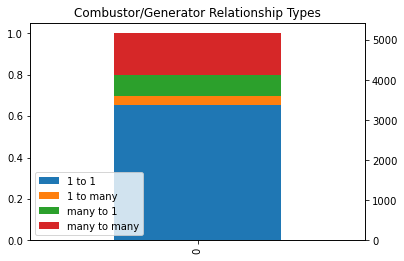

In [24]:
types = pd.Series([x['sum'] for x in [one_one, one_many, many_one, many_many]],
          index=['1 to 1', '1 to many', 'many to 1', 'many to many']
         ).to_frame().T
fig, ax = plt.subplots()
ax2 = ax.twinx()
types.div(types.sum(axis=1)[0]).plot.bar(stacked=True, ax=ax, legend=False)
types.plot.bar(stacked=True, title="Combustor/Generator Relationship Types", ax=ax2)

In [25]:
types.div(types.sum(axis=1)[0])

,1 to 1,1 to many,many to 1,many to many
0,0.655132,0.040595,0.102262,0.20201


In [26]:
test = (graph
        .fillna({'EIA_UNIT_TYPE': 'NaN'})
        .groupby(['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID', 'is_one_one'], as_index=False)['EIA_UNIT_TYPE']
        .agg(pd.Series.mode)
        .groupby(['EIA_UNIT_TYPE', 'is_one_one'], as_index=False)
        .size()
        .rename(columns={'size': 'count'})
       )

One-to-One generators have very different type composition to more complex generators.

Caveat: the complex plants can have multiple input types. I have assigned the most frequent value to the generator, which is not necessarily the highest capacity.

Text(0.5, 1.03, 'Generator Types by Combustor/Generator Relationship Complexity')

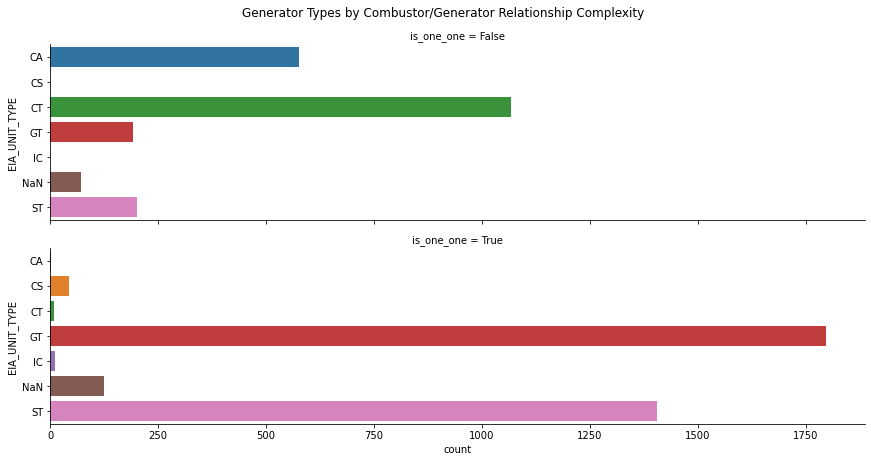

In [27]:
sns.catplot(data=test, x='count', row='is_one_one', y='EIA_UNIT_TYPE', kind='bar', orient='h', height=3, aspect=4)
plt.suptitle("Generator Types by Combustor/Generator Relationship Complexity", y=1.03)

#### A Weird plant

In [28]:
# this plant must be entirely made of pipes. Everything feeds into everything
cwalk.query("CAMD_PLANT_ID == 10865").sort_values(['CAMD_GENERATOR_ID', 'CAMD_UNIT_ID'])[subset]

,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,CAMD_NAMEPLATE_CAPACITY,EIA_PLANT_NAME,EIA_PLANT_ID,EIA_GENERATOR_ID,EIA_NAMEPLATE_CAPACITY,EIA_BOILER_ID,EIA_UNIT_TYPE,EIA_FUEL_TYPE
4161,Archer Daniels Midland Co.,10865,FBC1,GEN2,NaN,Archer Daniels Midland Decatur,10865.0,GEN2,31.0,CFB1,ST,BIT
4168,Archer Daniels Midland Co.,10865,FBC2,GEN2,NaN,Archer Daniels Midland Decatur,10865.0,GEN2,31.0,CFB2,ST,BIT
4175,Archer Daniels Midland Co.,10865,FBC3,GEN2,NaN,Archer Daniels Midland Decatur,10865.0,GEN2,31.0,CFB3,ST,BIT
4182,Archer Daniels Midland Co.,10865,FBC4,GEN2,NaN,Archer Daniels Midland Decatur,10865.0,GEN2,31.0,CFB4,ST,BIT
4189,Archer Daniels Midland Co.,10865,FBC5,GEN2,NaN,Archer Daniels Midland Decatur,10865.0,GEN2,31.0,CFB5,ST,BIT
...,...,...,...,...,...,...,...,...,...,...,...,...
4209,Archer Daniels Midland Co.,10865,FBC7,GEN8,NaN,Archer Daniels Midland Decatur,10865.0,GEN8,105.0,CFB7,ST,BIT
4216,Archer Daniels Midland Co.,10865,FBC8,GEN8,NaN,Archer Daniels Midland Decatur,10865.0,GEN8,105.0,CFB8,ST,BIT
4223,Archer Daniels Midland Co.,10865,FBC9,GEN8,NaN,Archer Daniels Midland Decatur,10865.0,GEN8,105.0,CFB9,ST,BIT
4224,Archer Daniels Midland Co.,10865,GB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# all states, 1 year
cols = ['plant_id_eia', 'unitid', 'operating_datetime_utc',
        'operating_time_hours', 'gross_load_mw', 'steam_load_1000_lbs',
        'heat_content_mmbtu', 'facility_id', 'unit_id_epa',
       ]

In [30]:
first_cems = (load_epacems(states=None, years=[2019], columns=cols, engine='pandas')
              .groupby('unit_id_epa', as_index=False).first())

In [31]:
# no duplicates on plant/unit
first_cems[first_cems.duplicated(subset=['plant_id_eia', 'unitid'])]

,unit_id_epa,plant_id_eia,unitid,operating_datetime_utc,operating_time_hours,gross_load_mw,steam_load_1000_lbs,heat_content_mmbtu,facility_id


In [32]:
first_cems.query('plant_id_eia == 10745', engine='python') # can't query pd.Int32 unless python engine is used

,unit_id_epa,plant_id_eia,unitid,operating_datetime_utc,operating_time_hours,gross_load_mw,steam_load_1000_lbs,heat_content_mmbtu,facility_id
3174,88567,10745,003,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3175,88568,10745,004,2019-01-01 05:00:00+00:00,1.0,89.0,NaN,934.299988,7755
3176,88569,10745,005,2019-01-01 05:00:00+00:00,1.0,87.0,NaN,940.400024,7755
3177,88570,10745,006,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3178,88571,10745,007,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3179,88572,10745,008,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3180,88573,10745,009,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3181,88574,10745,010,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3182,88575,10745,011,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3183,88576,10745,012,2019-01-01 05:00:00+00:00,1.0,88.0,NaN,990.200012,7755


There really are 18 inputs to one steam turbine... Some only report steam though, maybe because this is a cogen facility?

**EPA docs did note that steam turbine generators have the option of reporting electrical OR steam production.** I'll need to examine non-cogen steam-only units and see if they need special ramp rate treatment. They are currently excluded from analysis.

### EPA vs EIA

In [33]:
cwalk['CAMD_FUEL_TYPE'].value_counts()

Pipeline Natural Gas    4557
Coal                    1210
Diesel Oil               508
Natural Gas              174
Process Gas              147
Residual Oil             114
Other Gas                 53
Wood                      47
Other Oil                 34
Coal Refuse               14
Petroleum Coke            10
Tire Derived Fuel          3
Other Solid Fuel           2
Name: CAMD_FUEL_TYPE, dtype: int64

In [34]:
cwalk['EIA_FUEL_TYPE'].value_counts()

NG     4579
BIT     615
SUB     348
DFO     346
RC      107
KER      85
RFO      82
WDS      48
OG       48
BLQ      35
BFG      33
WC       25
LIG      20
PC        9
SGC       5
JF        5
LFG       4
MSW       4
SUN       3
WO        2
TDF       2
SGP       1
OBS       1
Name: EIA_FUEL_TYPE, dtype: int64

In [35]:
cwalk.groupby(['EIA_FUEL_TYPE', 'CAMD_FUEL_TYPE'])[['SEQUENCE_NUMBER']].count().unstack().fillna('-')

SEQUENCE_NUMBER                                               \
CAMD_FUEL_TYPE            Coal Coal Refuse Diesel Oil Natural Gas Other Gas   
EIA_FUEL_TYPE                                                                 
BFG                          -           -          -           -       3.0   
BIT                      569.0           -        1.0         4.0       2.0   
BLQ                       15.0           -          -        10.0         -   
DFO                        1.0           -      339.0         1.0         -   
JF                           -           -        1.0           -         -   
KER                          -           -       63.0           -         -   
LFG                          -           -          -           -       4.0   
LIG                       19.0           -          -           -         -   
MSW                          -           -          -         2.0         -   
NG                        28.0           -       82.0       135.0      23.0   
OBS                          -           -          -           -         -   
OG                           -           -          -           -       3.0   
PC                           -           -          -           -         -   
RC                       106.0           -          -           -         -   
RFO                          -           -        1.0           -         -   
SGC                        4.0           -          -           -         -   
SGP                          -           -          -           -         -   
SUB                      333.0           -          -           -         -   
SUN                          -           -          -           -         -   
TDF                          -           -          -           -         -   
WC                        11.0        14.0          -           -         -   
WDS                        2.0           -          -         2.0         -   
WO                           -           -          -           -         -   

                                                                               \
CAMD_FUEL_TYPE Other Oil Other Solid Fuel Petroleum Coke Pipeline Natural Gas   
EIA_FUEL_TYPE                                                                   
BFG                    -                -              -                  2.0   
BIT                    -                -              -                 18.0   
BLQ                  1.0                -              -                  6.0   
DFO                  2.0                -              -                  3.0   
JF                   4.0                -              -                    -   
KER                 18.0                -              -                  4.0   
LFG                    -                -              -                    -   
LIG                    -                -              -                    -   
MSW                    -                -              -                  2.0   
NG                   1.0                -              -               4284.0   
OBS                    -                -              -                    -   
OG                     -                -              -                    -   
PC                     -                -            7.0                    -   
RC                     -                -              -                  1.0   
RFO                  1.0                -              -                 11.0   
SGC                    -                -              -                  1.0   
SGP                    -                -              -                  1.0   
SUB                    -                -              -                  7.0   
SUN                    -                -              -                  3.0   
TDF                    -                -              -                    -   
WC                     -                -              -                    -   
WDS             

<AxesSubplot:>

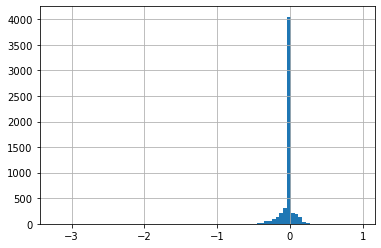

In [36]:
(cwalk['CAMD_NAMEPLATE_CAPACITY']
 .sub(cwalk['EIA_NAMEPLATE_CAPACITY'])
 .div(cwalk['CAMD_NAMEPLATE_CAPACITY'])
 .hist(bins=80,))# log=True))

<AxesSubplot:>

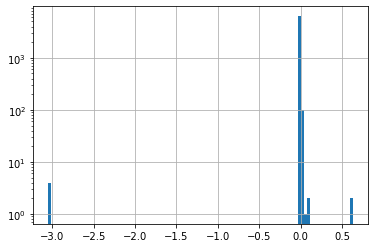

In [37]:
cwalk['CAMD_LATITUDE'].sub(cwalk['EIA_LATITUDE']).hist(bins=100, log=True)

<AxesSubplot:>

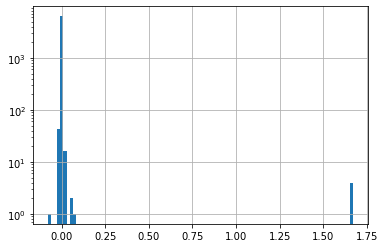

In [38]:
cwalk['CAMD_LONGITUDE'].sub(cwalk['EIA_LONGITUDE']).hist(bins=100, log=True)